In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Disable scientific notation for large numbers
pd.options.display.float_format = '{:.0f}'.format

# Setting display options for Pandas to show three decimal places for floating-point numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Data Loading

In [2]:
# import data
customer_df = pd.read_csv('/content/drive/MyDrive/Customer_data.csv')

# Data Exploration

In [3]:
customer_df.info()  # Display information about the dataFrame, including data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
customer_df.head()  # Display top 5 records

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [8]:
customer_df[['Annual_Income_(k$)','Spending_Score']].describe() # Display statistical information about dataframe

,Annual_Income_(k$),Spending_Score
count,200.00,200.00
mean,60.56,50.20
std,26.26,25.82
min,15.00,1.00
25%,41.50,34.75
50%,61.50,50.00
75%,78.00,73.00
max,137.00,99.00


# Data Preprocessing

In [9]:
customer_df.isna().sum()  # Find sum of missing values

,0
CustomerID,0
Genre,0
Age,0
Annual_Income_(k$),0
Spending_Score,0


Since, sum of missing values is zero, so there is no need to handle null values.

In [11]:
print(customer_df.duplicated().sum()) # Find sum of duplicate records

0


Since, sum of duplicated values is zero, so there is no need to drop duplicates.

Standardize the data using StandardScaler

In [12]:
# Select features to be scaled
features = customer_df[['Age', 'Annual_Income_(k$)', 'Spending_Score']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)


# Clustering

Determine the optimal number of clusters using the Elbow Method.

In [13]:
from sklearn.cluster import KMeans

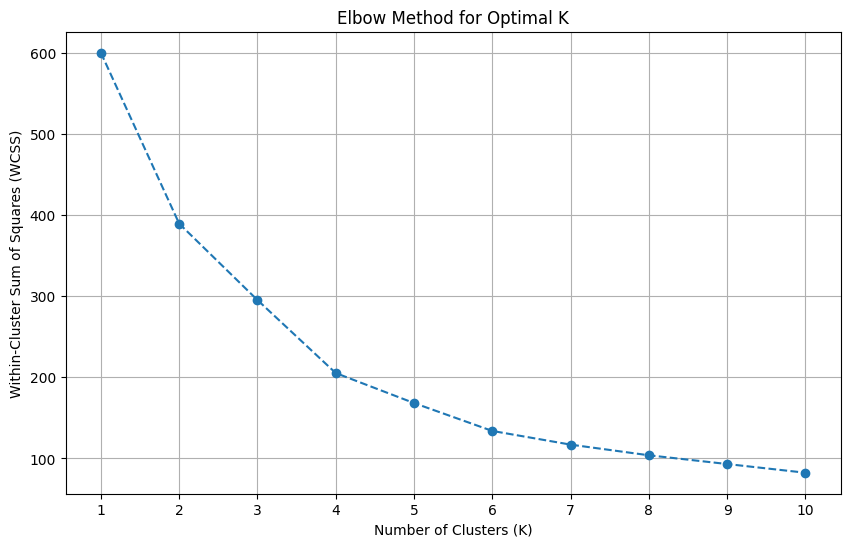

In [14]:
# Calculate WCSS for k=1 to 10
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


Apply K-Means Clustering and assign a cluster label to each customer.

In [15]:
n_clusters = 10

# Fit KMeans
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

# Assign cluster labels to the original data
customer_df['Cluster'] = clusters

# Output the result
print(customer_df[['CustomerID', 'Genre', 'Age', 'Annual_Income_(k$)', 'Spending_Score', 'Cluster']])


     CustomerID   Genre  Age  Annual_Income_(k$)  Spending_Score  Cluster
0             1    Male   19                  15              39        9
1             2    Male   21                  15              81        3
2             3  Female   20                  16               6        9
3             4  Female   23                  16              77        3
4             5  Female   31                  17              40        9
..          ...     ...  ...                 ...             ...      ...
195         196  Female   35                 120              79        8
196         197  Female   45                 126              28        2
197         198    Male   32                 126              74        8
198         199    Male   32                 137              18        2
199         200    Male   30                 137              83        8

[200 rows x 6 columns]


In [ ]:
# Save cleaned data
customer_df.to_csv('/content/drive/MyDrive/Customer_data_final.csv', index=False)

# Data Visualization

Create 2D Scatter Plot by using PCA (Principal Component Analysis) or t-SNE to reduce dimensions to two for visualization

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


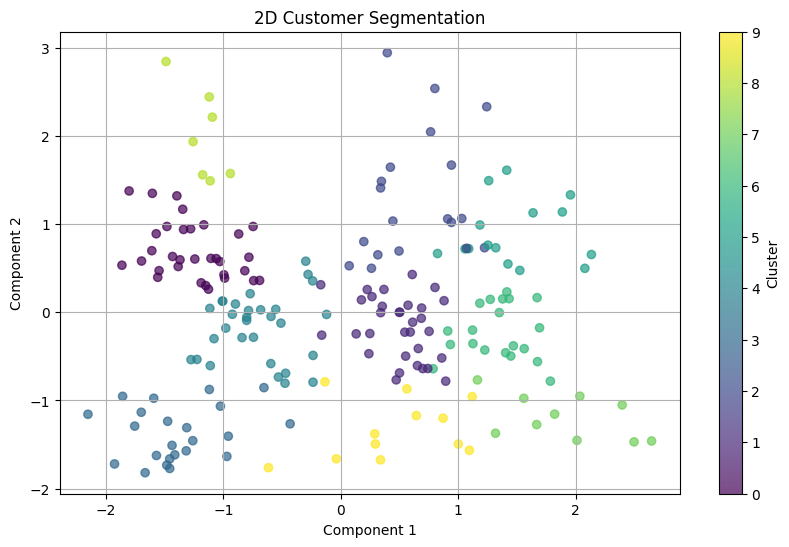

In [17]:
# Method 1: PCA (Faster, linear dimensionality reduction)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Method 2: t-SNE (Slower, non-linear, preserves local structure)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# pca_result = tsne.fit_transform(scaled_features)

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                      c=customer_df['Cluster'] if 'Cluster' in customer_df.columns else 'blue',
                      cmap='viridis', alpha=0.7)

plt.title('2D Customer Segmentation')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Add colorbar if clusters exist
if 'Cluster' in customer_df.columns:
    plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


Create Pair Plots to visualize relationships between features within clusters.

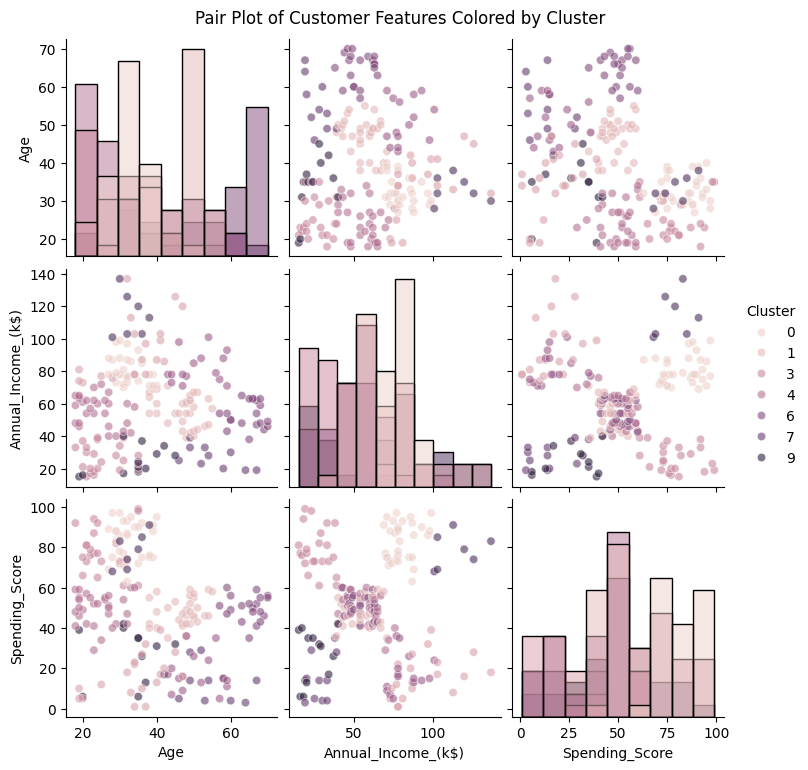

In [19]:
# Select features for the pair plot
plot_features = ['Age', 'Annual_Income_(k$)', 'Spending_Score', 'Cluster']

# Create pair plot colored by cluster
sb.pairplot(customer_df[plot_features], hue='Cluster', diag_kind='hist', plot_kws={'alpha':0.6}, height=2.5)
plt.suptitle('Pair Plot of Customer Features Colored by Cluster', y=1.02)
plt.show()


Create Centroid Visuals to show the centroid of each cluster for better interpretation.

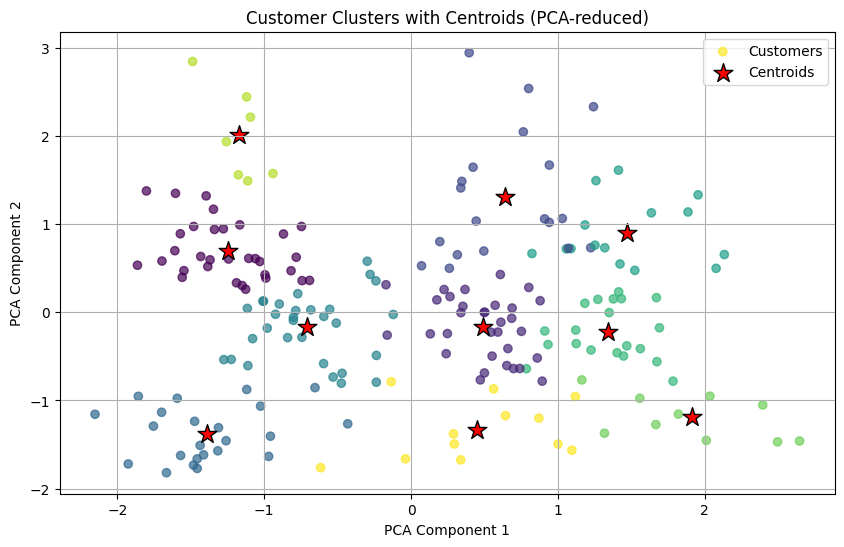

In [20]:
# Get centroids in original feature space and transform to PCA space
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Plot the data points
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.7, label='Customers')

# Plot the centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='*', s=200, c='red', edgecolor='black', label='Centroids')

plt.title('Customer Clusters with Centroids (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


# Recommendations

Recommand which groups to target for promotions or premium products.

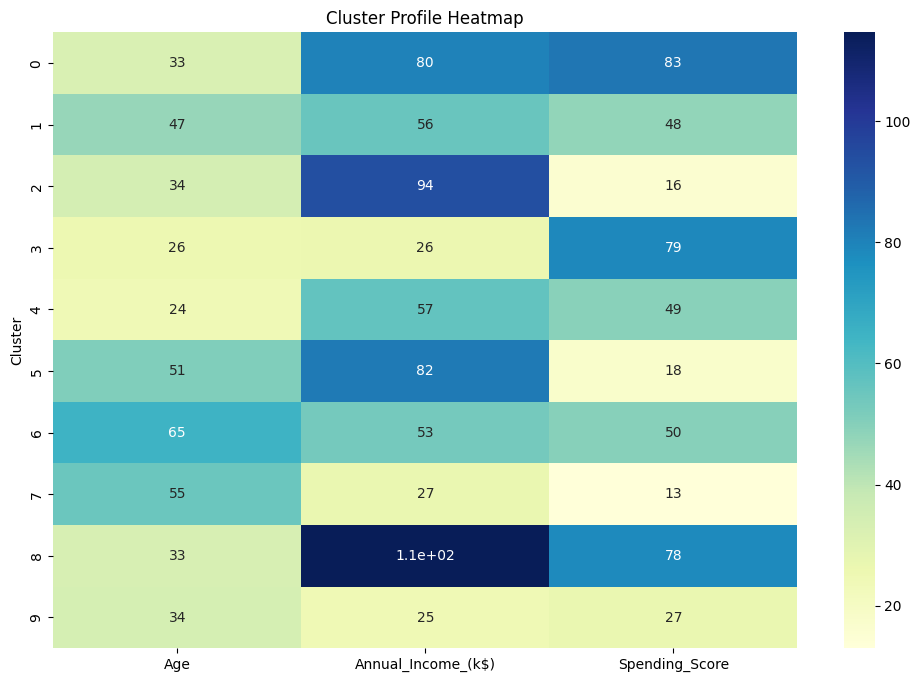


Targeting Recommendations:
- Cluster 0: Target for PREMIUM products (High-income: $80.4k, High spending: 82.9 score)
- Cluster 1: Maintain engagement (Moderate value)
- Cluster 2: Upsell opportunities (Young high-earners: $93.9k)
- Cluster 3: Ideal for PROMOTIONS (High spending: 78.6 score)
- Cluster 4: Maintain engagement (Moderate value)
- Cluster 5: Maintain engagement (Moderate value)
- Cluster 6: Maintain engagement (Moderate value)
- Cluster 7: Maintain engagement (Moderate value)
- Cluster 8: Target for PREMIUM products (High-income: $114.7k, High spending: 78.4 score)
- Cluster 9: Maintain engagement (Moderate value)


In [21]:
# Analyze cluster characteristics
cluster_profile = customer_df.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual_Income_(k$)': 'mean',
    'Spending_Score': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

# Visualize cluster profiles
plt.figure(figsize=(12, 8))
sb.heatmap(cluster_profile.drop('Count', axis=1), annot=True, cmap='YlGnBu')
plt.title('Cluster Profile Heatmap')
plt.show()

# Generate targeting recommendations
def generate_recommendations(profile):
    recommendations = []

    for cluster_id, row in profile.iterrows():
        age = row['Age']
        income = row['Annual_Income_(k$)']
        spending = row['Spending_Score']
        size = row['Count']

        if income > 80 and spending > 70:
            rec = f"Cluster {cluster_id}: Target for PREMIUM products (High-income: ${income:.1f}k, High spending: {spending:.1f} score)"
        elif spending > 60:
            rec = f"Cluster {cluster_id}: Ideal for PROMOTIONS (High spending: {spending:.1f} score)"
        elif income > 70 and age < 40:
            rec = f"Cluster {cluster_id}: Upsell opportunities (Young high-earners: ${income:.1f}k)"
        else:
            rec = f"Cluster {cluster_id}: Maintain engagement (Moderate value)"

        recommendations.append(rec)

    return recommendations

# Execute and print recommendations
recommendations = generate_recommendations(cluster_profile)
print("\nTargeting Recommendations:")
for rec in recommendations:
    print(f"- {rec}")


Identify high-spending customers and propose loyalty programs.

In [22]:
# Define high-spending threshold (top 20% by Spending_Score)
threshold = customer_df['Spending_Score'].quantile(0.8)
high_spenders = customer_df[customer_df['Spending_Score'] >= threshold]

# Print high-spending customers
print("High-Spending Customers:")
print(high_spenders[['CustomerID', 'Genre', 'Age', 'Annual_Income_(k$)', 'Spending_Score']])

# Propose loyalty programs based on customer characteristics
print("\nProposed Loyalty Programs for High-Spending Customers:")

for idx, customer in high_spenders.iterrows():
    # Premium tier for very high income and spending
    if customer['Annual_Income_(k$)'] > 80 and customer['Spending_Score'] > 80:
        program = (
            f"Customer {customer['CustomerID']}: Premium Loyalty Program (exclusive access, priority service, early sales)"
        )
    # Standard rewards for high spending
    elif customer['Spending_Score'] > 80:
        program = (
            f"Customer {customer['CustomerID']}: Rewards Program (points, discounts, birthday offers)"
        )
    # Upsell for younger high spenders
    elif customer['Age'] < 40 and customer['Spending_Score'] > 70:
        program = (
            f"Customer {customer['CustomerID']}: Upsell Program (targeted offers, new product trials)"
        )
    # General loyalty for other high spenders
    else:
        program = (
            f"Customer {customer['CustomerID']}: General Loyalty Program (free shipping, member-only deals)"
        )
    print(program)


High-Spending Customers:
     CustomerID   Genre  Age  Annual_Income_(k$)  Spending_Score
1             2    Male   21                  15              81
3             4  Female   23                  16              77
5             6  Female   22                  17              76
7             8  Female   23                  18              94
11           12  Female   35                  19              99
13           14  Female   24                  20              77
15           16    Male   22                  20              79
19           20  Female   35                  23              98
25           26    Male   29                  28              82
29           30  Female   23                  29              87
33           34    Male   18                  33              92
35           36  Female   21                  33              81
39           40  Female   20                  37              75
41           42    Male   24                  38              92


Tailor marketing strategies for different age or income segments.

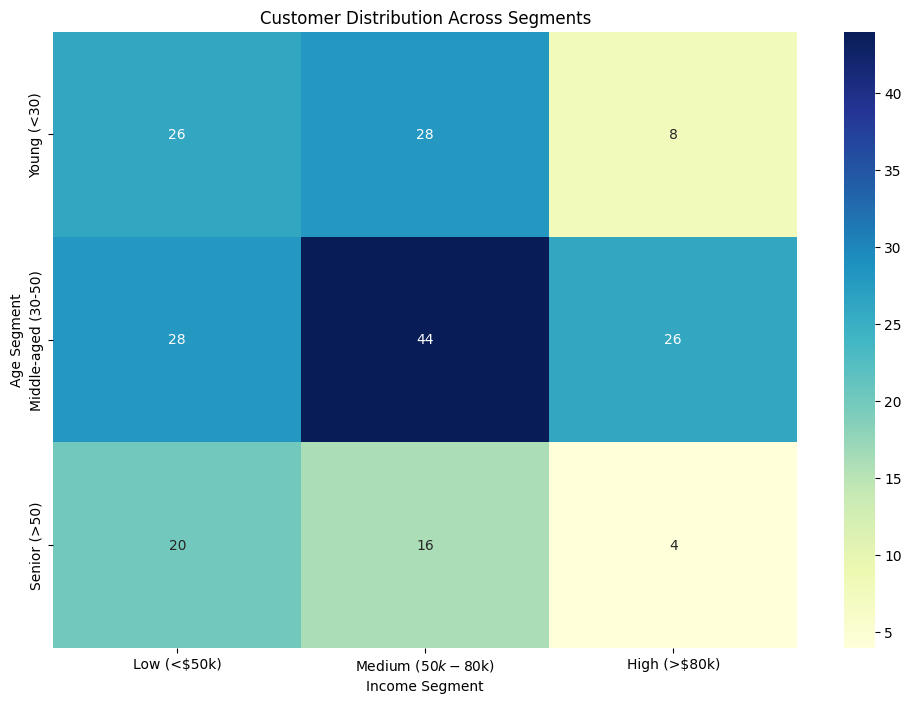


Tailored Marketing Strategies:
           Age Segment      Income Segment  Customer_Count  \
0          Young (<30)         Low (<$50k)              26   
1          Young (<30)  Medium ($50k-$80k)              28   
2          Young (<30)        High (>$80k)               8   
3  Middle-aged (30-50)         Low (<$50k)              28   
4  Middle-aged (30-50)  Medium ($50k-$80k)              44   
5  Middle-aged (30-50)        High (>$80k)              26   
6         Senior (>50)         Low (<$50k)              20   
7         Senior (>50)  Medium ($50k-$80k)              16   
8         Senior (>50)        High (>$80k)               4   

                                            Strategy  
0  Entry-level offers: Student discounts, budget-...  
1  Value bundles: Mid-range fashion, subscription...  
2  Luxury trend-focused campaigns: Premium tech/e...  
3  Budget solutions: Value packs, discount events...  
4  Quality-focused promotions: Durable goods, loy...  
5  Premium family

In [24]:
# Define segmentation boundaries
age_bins = [0, 30, 50, 100]
age_labels = ['Young (<30)', 'Middle-aged (30-50)', 'Senior (>50)']
income_bins = [0, 50, 80, 200]
income_labels = ['Low (<$50k)', 'Medium ($50k-$80k)', 'High (>$80k)']

# Create segments
customer_df['Age Segment'] = pd.cut(customer_df['Age'], bins=age_bins, labels=age_labels)
customer_df['Income Segment'] = pd.cut(customer_df['Annual_Income_(k$)'], bins=income_bins, labels=income_labels)

# Analyze segment characteristics
segment_analysis = customer_df.groupby(['Age Segment', 'Income Segment']).agg(
    Avg_Spending=('Spending_Score', 'mean'),
    Customer_Count=('CustomerID', 'count')
).reset_index()

# Visualize segment distribution
plt.figure(figsize=(12, 8))
sb.heatmap(
    segment_analysis.pivot_table(index='Age Segment', columns='Income Segment', values='Customer_Count'),
    annot=True, cmap='YlGnBu'
)
plt.title('Customer Distribution Across Segments')
plt.show()

# Propose tailored marketing strategies
def propose_strategies(row):
    age = row['Age Segment']
    income = row['Income Segment']
    spending = row['Avg_Spending']
    count = row['Customer_Count']

    if age == 'Young (<30)':
        if income == 'High (>$80k)':
            return "Luxury trend-focused campaigns: Premium tech/experience products, influencer partnerships"
        elif income == 'Medium ($50k-$80k)':
            return "Value bundles: Mid-range fashion, subscription models, social media engagement"
        else:
            return "Entry-level offers: Student discounts, budget-friendly options, TikTok campaigns"

    elif age == 'Middle-aged (30-50)':
        if income == 'High (>$80k)':
            return "Premium family packages: High-end home goods, exclusive memberships, concierge service"
        elif income == 'Medium ($50k-$80k)':
            return "Quality-focused promotions: Durable goods, loyalty programs, email marketing"
        else:
            return "Budget solutions: Value packs, discount events, community-focused messaging"

    else:  # Senior (>50)
        if income == 'High (>$80k)':
            return "Luxury leisure: High-end travel, premium health services, personalized consultations"
        elif income == 'Medium ($50k-$80k)':
            return "Comfort-focused: Quality-of-life products, loyalty benefits, newsletter offers"
        else:
            return "Essential value: Senior discounts, basic necessities, traditional media outreach"

# Generate and display strategies
segment_analysis['Strategy'] = segment_analysis.apply(propose_strategies, axis=1)
print("\nTailored Marketing Strategies:")
print(segment_analysis[['Age Segment', 'Income Segment', 'Customer_Count', 'Strategy']])
